In [1]:
# if (!require("BiocManager", quietly = TRUE))
#    install.packages("BiocManager")

# BiocManager::install("curatedTCGAData");
# BiocManager::install("TCGAutils");
# BiocManager::install("TCGAbiolinks");
# BiocManager::install("NetPreProc");
# BiocManager::install("remotes");

# install.packages("SNFtool");
# install.packages("caret");
# install.packages("cluster");
# install.packages("mclustcomp");
# install.packages("tsne");
#install.packages("factoextra");

In [2]:
library("curatedTCGAData");
library("TCGAbiolinks");
library("TCGAutils");
library("SNFtool");
library("NetPreProc");
library("caret");
library("cluster"); #pam
library("mclustcomp");
library("factoextra");

Caricamento del pacchetto richiesto: MultiAssayExperiment

Caricamento del pacchetto richiesto: SummarizedExperiment

Caricamento del pacchetto richiesto: MatrixGenerics

Caricamento del pacchetto richiesto: matrixStats


Caricamento pacchetto: ‘MatrixGenerics’


I seguenti oggetti sono mascherati da ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMad

In [3]:
# Download prostate cancer multi-omics dataset.
# Note that RPPA stands for Reverse-phase protein array and it is the technology used to obtain proteomic data.
assays <- c("miRNASeqGene", "RNASeq2Gene", "RPPAArray");
mo <- curatedTCGAData(diseaseCode = "PRAD", 
                        assays = assays, 
                        version = "2.0.1", dry.run = FALSE);

# This command print a summary of the MultiAssayExperiemnt object.
mo;

snapshotDate(): 2022-10-31

Working on: PRAD_miRNASeqGene-20160128

see ?curatedTCGAData and browseVignettes('curatedTCGAData') for documentation

loading from cache

Working on: PRAD_RNASeq2Gene-20160128

see ?curatedTCGAData and browseVignettes('curatedTCGAData') for documentation

loading from cache

Working on: PRAD_RPPAArray-20160128

see ?curatedTCGAData and browseVignettes('curatedTCGAData') for documentation

loading from cache

Working on: PRAD_colData-20160128

see ?curatedTCGAData and browseVignettes('curatedTCGAData') for documentation

loading from cache

Working on: PRAD_metadata-20160128

see ?curatedTCGAData and browseVignettes('curatedTCGAData') for documentation

loading from cache

Working on: PRAD_sampleMap-20160128

see ?curatedTCGAData and browseVignettes('curatedTCGAData') for documentation

loading from cache

harmonizing input:
  removing 5189 sampleMap rows not in names(experiments)



A MultiAssayExperiment object of 3 listed
 experiments with user-defined names and respective classes.
 Containing an ExperimentList class object of length 3:
 [1] PRAD_miRNASeqGene-20160128: SummarizedExperiment with 1046 rows and 547 columns
 [2] PRAD_RNASeq2Gene-20160128: SummarizedExperiment with 20501 rows and 550 columns
 [3] PRAD_RPPAArray-20160128: SummarizedExperiment with 195 rows and 352 columns
Functionality:
 experiments() - obtain the ExperimentList instance
 colData() - the primary/phenotype DataFrame
 sampleMap() - the sample coordination DataFrame
 `$`, `[`, `[[` - extract colData columns, subset, or experiment
 *Format() - convert into a long or wide DataFrame
 assays() - convert ExperimentList to a SimpleList of matrices
 exportClass() - save data to flat files

In [4]:
# This subset does not change the content of the variable "mo" if using the version 4.2.0 of R.
mo <- mo[, , paste0("PRAD", "_", assays, "-20160128")];

In [5]:
# Checking the actual number of entries in the sampleMap. It can be noticed that the number of entries in the
# sampleMap DataFrame is still the same after the subsetting (1449 rows and 3 columns).
sampleMap(mo);

DataFrame with 1449 rows and 3 columns
                         assay      primary                colname
                      <factor>  <character>            <character>
1    PRAD_RNASeq2Gene-20160128 TCGA-2A-A8VL TCGA-2A-A8VL-01A-21R..
2    PRAD_RNASeq2Gene-20160128 TCGA-2A-A8VO TCGA-2A-A8VO-01A-11R..
3    PRAD_RNASeq2Gene-20160128 TCGA-2A-A8VT TCGA-2A-A8VT-01A-11R..
4    PRAD_RNASeq2Gene-20160128 TCGA-2A-A8VV TCGA-2A-A8VV-01A-11R..
5    PRAD_RNASeq2Gene-20160128 TCGA-2A-A8VX TCGA-2A-A8VX-01A-11R..
...                        ...          ...                    ...
1445   PRAD_RPPAArray-20160128 TCGA-ZG-A9LZ TCGA-ZG-A9LZ-01A-21-..
1446   PRAD_RPPAArray-20160128 TCGA-ZG-A9M4 TCGA-ZG-A9M4-01A-21-..
1447   PRAD_RPPAArray-20160128 TCGA-ZG-A9MC TCGA-ZG-A9MC-01A-21-..
1448   PRAD_RPPAArray-20160128 TCGA-ZG-A9N3 TCGA-ZG-A9N3-01A-22-..
1449   PRAD_RPPAArray-20160128 TCGA-ZG-A9NI TCGA-ZG-A9NI-01A-21-..

In [6]:
# We extract the samples knowing that the type of tumor is indicated in the barcode. In TCGA “Primary Solid Tumors”
# are identified by the code “01” in the sample part of the barcode.
# Consider only primary solid tumors because primary tumors originate in a specific organ or tissue and are
# generally more consistent in terms of location, size, and characteristics compared to metastatic tumors
# (secondary tumors that spread from the primary site). Focusing on primary tumors helps maintain statistical
# validity by comparing similar types of tumors, reducing variability and confounding factors that may arise
# from studying different metastatic sites.
primary <- TCGAutils::TCGAsampleSelect(colnames(mo), c("01"));
primary;

Warning message in .checkBarcodes(barcodes, check.sample = TRUE):
“Inconsistent barcode lengths: 28, 27”
Warning message in .checkBarcodes(barcodes):
“Inconsistent barcode lengths: 28, 27”


LogicalList of length 3
[["PRAD_miRNASeqGene-20160128"]] 01=TRUE 01=TRUE 01=TRUE ... 01=TRUE 01=TRUE
[["PRAD_RNASeq2Gene-20160128"]] 01=TRUE 01=TRUE 01=TRUE ... 01=TRUE 01=TRUE
[["PRAD_RPPAArray-20160128"]] 01=TRUE 01=TRUE 01=TRUE ... 01=TRUE 01=TRUE

In [7]:
# The execution of the precedent cell raises a warnin due to the fact that the barcode associated with
# the RPPAArray is composed by 27 characters while the others are composed by 28 characters.
print(colnames(mo)[1]);
print(colnames(mo)[2]);
print(colnames(mo)[3]);

CharacterList of length 1
[["PRAD_miRNASeqGene-20160128"]] TCGA-2A-A8VL-01A-21R-A37H-13 ...
CharacterList of length 1
[["PRAD_RNASeq2Gene-20160128"]] TCGA-2A-A8VL-01A-21R-A37L-07 ...
CharacterList of length 1
[["PRAD_RPPAArray-20160128"]] TCGA-2A-A8VL-01A-11-A43M-20 ...


In [8]:
mo <- mo[, primary, ];

harmonizing input:
  removing 106 sampleMap rows with 'colname' not in colnames of experiments



In [9]:
# Checking the actual number of entries in the sampleMap (1343 rows and 3 columns).
sampleMap(mo);

DataFrame with 1343 rows and 3 columns
                         assay      primary                colname
                      <factor>  <character>            <character>
1    PRAD_RNASeq2Gene-20160128 TCGA-2A-A8VL TCGA-2A-A8VL-01A-21R..
2    PRAD_RNASeq2Gene-20160128 TCGA-2A-A8VO TCGA-2A-A8VO-01A-11R..
3    PRAD_RNASeq2Gene-20160128 TCGA-2A-A8VT TCGA-2A-A8VT-01A-11R..
4    PRAD_RNASeq2Gene-20160128 TCGA-2A-A8VV TCGA-2A-A8VV-01A-11R..
5    PRAD_RNASeq2Gene-20160128 TCGA-2A-A8VX TCGA-2A-A8VX-01A-11R..
...                        ...          ...                    ...
1339   PRAD_RPPAArray-20160128 TCGA-ZG-A9LZ TCGA-ZG-A9LZ-01A-21-..
1340   PRAD_RPPAArray-20160128 TCGA-ZG-A9M4 TCGA-ZG-A9M4-01A-21-..
1341   PRAD_RPPAArray-20160128 TCGA-ZG-A9MC TCGA-ZG-A9MC-01A-21-..
1342   PRAD_RPPAArray-20160128 TCGA-ZG-A9N3 TCGA-ZG-A9N3-01A-22-..
1343   PRAD_RPPAArray-20160128 TCGA-ZG-A9NI TCGA-ZG-A9NI-01A-21-..

In [10]:
# Check for replicates (anyReplicated() checks the so called biological or primary unit in the sampleMap of the
# MultiAssayExperiment object, that corresponds to the first 12 characters of the barcodes for TCGA data). In fact,
# If two samples have the same 12 characters in their barcodes, then they come from the same patient and can be
# identified as technical replicated (since we already filtered for the same sample type). The outcome ("FALSE")
# indicates that there were no replicates.
check_rep <- anyReplicated(mo);
print(check_rep);

 PRAD_RNASeq2Gene-20160128 PRAD_miRNASeqGene-20160128 
                     FALSE                      FALSE 
   PRAD_RPPAArray-20160128 
                     FALSE 


In [11]:
# The information regarding if the sample is FFPE is stored in the clinical data, which are accessible using
# colData(). 
no_ffpe <- which(as.data.frame(colData(mo))$patient.samples.sample.is_ffpe == "no");

In [12]:
mo <- mo[, no_ffpe, ];

In [13]:
# Checking the actual number of entries in the sampleMap (1343 rows and 3 columns);
sampleMap(mo);

DataFrame with 1343 rows and 3 columns
                         assay      primary                colname
                      <factor>  <character>            <character>
1    PRAD_RNASeq2Gene-20160128 TCGA-2A-A8VL TCGA-2A-A8VL-01A-21R..
2    PRAD_RNASeq2Gene-20160128 TCGA-2A-A8VO TCGA-2A-A8VO-01A-11R..
3    PRAD_RNASeq2Gene-20160128 TCGA-2A-A8VT TCGA-2A-A8VT-01A-11R..
4    PRAD_RNASeq2Gene-20160128 TCGA-2A-A8VV TCGA-2A-A8VV-01A-11R..
5    PRAD_RNASeq2Gene-20160128 TCGA-2A-A8W1 TCGA-2A-A8W1-01A-11R..
...                        ...          ...                    ...
1339   PRAD_RPPAArray-20160128 TCGA-ZG-A9LB TCGA-ZG-A9LB-01A-21-..
1340   PRAD_RPPAArray-20160128 TCGA-TP-A8TV TCGA-TP-A8TV-01A-21-..
1341   PRAD_RPPAArray-20160128 TCGA-V1-A9OX TCGA-V1-A9OX-01A-21-..
1342   PRAD_RPPAArray-20160128 TCGA-YL-A9WX TCGA-YL-A9WX-01A-11-..
1343   PRAD_RPPAArray-20160128 TCGA-ZG-A9L9 TCGA-ZG-A9L9-01A-21-..

In [14]:
# intersectColumns() is a wrapper for complete.cases to return a MultiAssayExperiment with only those biological
# units that have measurements across all experiments. We will obtain samples having all the considered omics
# (1044 rows and 3 columns).
complete <- intersectColumns(mo);
sampleMap(complete);

DataFrame with 1044 rows and 3 columns
                         assay      primary                colname
                      <factor>  <character>            <character>
1    PRAD_RNASeq2Gene-20160128 TCGA-2A-A8VL TCGA-2A-A8VL-01A-21R..
2    PRAD_RNASeq2Gene-20160128 TCGA-2A-A8VO TCGA-2A-A8VO-01A-11R..
3    PRAD_RNASeq2Gene-20160128 TCGA-2A-A8VT TCGA-2A-A8VT-01A-11R..
4    PRAD_RNASeq2Gene-20160128 TCGA-2A-A8VV TCGA-2A-A8VV-01A-11R..
5    PRAD_RNASeq2Gene-20160128 TCGA-2A-A8W1 TCGA-2A-A8W1-01A-11R..
...                        ...          ...                    ...
1040   PRAD_RPPAArray-20160128 TCGA-ZG-A9LB TCGA-ZG-A9LB-01A-21-..
1041   PRAD_RPPAArray-20160128 TCGA-TP-A8TV TCGA-TP-A8TV-01A-21-..
1042   PRAD_RPPAArray-20160128 TCGA-V1-A9OX TCGA-V1-A9OX-01A-21-..
1043   PRAD_RPPAArray-20160128 TCGA-YL-A9WX TCGA-YL-A9WX-01A-11-..
1044   PRAD_RPPAArray-20160128 TCGA-ZG-A9L9 TCGA-ZG-A9L9-01A-21-..

In [15]:
# Extract assays in list of matrices. To access an assay it is possible to use complete$assaysname
complete <- assays(complete);
complete;

List of length 3
names(3): PRAD_miRNASeqGene-20160128 PRAD_RNASeq2Gene-20160128 PRAD_RPPAArray-20160128

In [16]:
# Obtain matrices samples x features:
complete <- lapply(complete, FUN=t);
complete;

$`PRAD_miRNASeqGene-20160128`
                             hsa-let-7a-1 hsa-let-7a-2 hsa-let-7a-3 hsa-let-7b
TCGA-2A-A8VL-01A-21R-A37H-13        32458        65068        32654      68355
TCGA-2A-A8VO-01A-11R-A37H-13        19387        38457        19447      19162
TCGA-2A-A8VT-01A-11R-A37H-13        42690        85105        43247      36065
TCGA-2A-A8VV-01A-11R-A37H-13        62290       123325        61878      58422
TCGA-2A-A8W1-01A-11R-A37H-13        12750        24974        12584       6681
TCGA-2A-A8W3-01A-11R-A37H-13        28225        56756        28358      21738
TCGA-CH-5737-01A-11R-1579-13        75147       149632        75297      71861
TCGA-CH-5738-01A-11R-1579-13        41523        82750        41762      51346
TCGA-CH-5739-01A-11R-1579-13        75998       151246        76239      92385
TCGA-CH-5740-01A-11R-1579-13        42616        85659        42947      26142
TCGA-CH-5741-01A-11R-1579-13       103501       205751       103551     138414
TCGA-CH-5743-01A-21R-1579-13        40892        81828        41364      39048
TCGA-CH-5744-01A-11R-1579-13        48522        96655        48879      56144
TCGA-CH-5748-01A-11R-1579-13        30809        61662        30715      27886
TCGA-CH-5750-01A-11R-1579-13        36475        72969        36532      32085
TCGA-CH-5752-01A-11R-1579-13        47272        94806        47717      37720
TCGA-CH-5753-01A-11R-1579-13        30190        59796        30170      17797
TCGA-CH-5754-01A-11R-1579-13        46267        92333        46482      52579
TCGA-CH-5761-01A-11R-1579-13        28214        56593        28437      29821
TCGA-CH-5762-01A-11R-1579-13        76038       151408        75437      72924
TCGA-CH-5763-01A-11R-1579-13        52309       104365        52483      64924
TCGA-CH-5764-01A-21R-1579-13        45019        89783        45108      51438
TCGA-CH-5765-01A-11R-1579-13        33665        67652        33656      19059
TCGA-CH-5766-01A-11R-1579-13        44481        88890        44584      35769
TCGA-CH-5767-01A-11R-1788-13        18327        37450        18707      17667
TCGA-CH-5768-01A-11R-1579-13        34711        69430        34948      27993
TCGA-CH-5769-01A-11R-1579-13        34443        68952        34827      38177
TCGA-CH-5771-01A-21R-1579-13        25911        51862        25834      29134
TCGA-CH-5772-01A-11R-1579-13        86557       172085        86395      67474
TCGA-CH-5788-01A-11R-1579-13        18311        36039        18099      12296
TCGA-CH-5789-01A-11R-1579-13        55812       111644        56540      60005
TCGA-CH-5790-01A-11R-1579-13        37481        74657        37537      29212
TCGA-CH-5791-01A-11R-1579-13        44817        88843        44540      36647
TCGA-CH-5792-01A-11R-1579-13        27685        55717        27913      35244
TCGA-CH-5794-01A-11R-1579-13        52566       104601        52706      51033
TCGA-EJ-5494-01A-01R-1579-13       202918       405698       204203     452518
TCGA-EJ-5495-01A-01R-1579-13        28390        56370        28440      19279
TCGA-EJ-5496-01A-01R-1579-13        26671        53189        26830      16683
TCGA-EJ-5497-01A-02R-1579-13        71971       143801        73078      98212
TCGA-EJ-5498-01A-01R-1579-13        38923        77802        39289      34633
TCGA-EJ-5499-01A-01R-1579-13        28086        56614        28098      24296
TCGA-EJ-5501-01A-01R-1579-13        27895        55417        27854      36587
TCGA-EJ-5502-01A-01R-1579-13        18546        37539        18647      18589
TCGA-EJ-5503-01A-01R-1579-13        21165        41825        21020      22428
TCGA-EJ-5504-01A-01R-1579-13        28307        57061        28636      35548
TCGA-EJ-5505-01A-01R-1579-13        23101        46712        23167      22819
TCGA-EJ-5506-01A-01R-1579-13       159602       319720       160390     163771
TCGA-EJ-5507-01A-01R-1579-13        23965        47917        24130      27393
TCGA-EJ-5508-01A-02R-1579-13        23094        46221        23288      24995
TCGA-EJ-5509-01A-01R

In [17]:
# Remove features having NAs (present only in proteomics data).
# In details, "is.na(complete[[3]])" checks for missing values (NA) in the third matrix.
# "colSums(is.na(complete[[3]]))" calculates the column-wise sums of missing values. It returns a numeric vector
# with the same number of elements as the number of columns in complete[[3]]. Each element represents the count of
# missing values in the corresponding column.
# "colSums(is.na(complete[[3]])) == 0" creates a logical vector indicating which columns have no missing values.
# It returns TRUE for columns with no missing values and FALSE otherwise.
# "complete[[3]][, colSums(is.na(complete[[3]])) == 0]" selects columns from the proteomics matrix where the
# corresponding column in colSums(is.na(complete[[3]])) == 0 is TRUE. In other words, it keeps only the columns
# that have no missing values.
complete[[1]] <- complete[[1]][, colSums(is.na(complete[[1]])) == 0];
complete[[2]] <- complete[[2]][, colSums(is.na(complete[[2]])) == 0];
complete[[3]] <- complete[[3]][, colSums(is.na(complete[[3]])) == 0];

In [18]:
# Remove features with near zero variance and retain top 100 features having higher variance.
# First, we define the number of features we want to retain.
# We loop on each one of the data matrices.
# "nearZeroVar()", from the caret package, is used to identify variables with near-zero variance, which means they
# have very little or no variation in their values. The resulting indices are stored in the "idx" variable.
# Then, if the length of the "idx" variable is not zero, the expression "complete[[i]][, -idx]"" is used to subset
# the i-th element of complete and remove the columns specified by the idx variable. Then, it modifies the i-th
# element within the "complete" list by removing the columns identified by "idx" from that element.
# The modified element is then assigned back to the i-th position in the "complete" list.
# "if(ncol(complete[[i]]) <= nf)" next is a conditional statement which checks if the number of columns (features) in
# the modified i-th element of "complete" is less than or equal to "nf" (100 in this case). If it is, the "next"
# keyword is used to skip the remaining operations within the loop for the current i and move on to the next
# iteration.
# "vars <- apply(complete[[i]], 2, var);" calculates the variance of each column (feature) in the modified i-th
# element of "complete".
# "idx <- sort(vars, index.return=TRUE, decreasing = TRUE)$ix;" sorts the variance values ("vars") in descending
# order and retrieves the corresponding indices ("ix"). It stores the sorted indices in the "idx" variable.
# Finally, "complete[[i]] <- complete[[i]][, idx[1:nf]];" keeps only the top 100 features in the modified i-th
# element of "complete". It uses the sorted indices "idx" to select the first "nf" elements and retains only those
# columns. The modified matrix is then assigned back to the i-th position in the "complete" list.
# (Removed 418 features from PRAD_miRNASeqGene-20160128)
# (Removed  1334 features from PRAD_RNASeq2Gene-20160128)
# (Removed  0 features from PRAD_RPPAArray-20160128)
nf <- 100;
for(i in 1:length(complete)){
    
    idx <- caret::nearZeroVar(complete[[i]]);
    message(paste("Removed ", length(idx), "features from", names(complete)[i]));
    if(length(idx) != 0){
        complete[[i]] <- complete[[i]][, -idx];
    }

    if(ncol(complete[[i]]) <= nf) next
    
    vars <- apply(complete[[i]], 2, var);
    idx <- sort(vars, index.return=TRUE, decreasing = TRUE)$ix;
    
    complete[[i]] <- complete[[i]][, idx[1:nf]];
    
}

Removed  418 features from PRAD_miRNASeqGene-20160128

Removed  1334 features from PRAD_RNASeq2Gene-20160128

Removed  0 features from PRAD_RPPAArray-20160128



In [19]:
# Perform features standardization using z-score.
zscore <- function(data){
    
    zscore_vec <- function(x) { return ((x - mean(x)) / sd(x))};
    data <- apply(data, 2, zscore_vec);
    
    
    return(data);
}

complete <- lapply(complete, zscore);

In [20]:
for(v in 1:length(complete)){
    rownames(complete[[v]]) <- substr(rownames(complete[[v]]), 1, 12);
}

In [21]:
# Download disease subtypes (prostate adenocarcinoma) from TCGAbiolinks. The column “Subtype_Integrative” is the
# one containing the iCluster molecular subtype.
subtypes <- as.data.frame(TCGAbiolinks::PanCancerAtlas_subtypes());
subtypes <- subtypes[subtypes$cancer.type == "PRAD", ];
subtypes;

pan.samplesID   cancer.type Subtype_mRNA Subtype_DNAmeth Subtype_protein
5978 TCGA-HC-7818-01 PRAD        3            4               NA             
5979 TCGA-HC-7077-01 PRAD        2            1                1             
5980 TCGA-G9-6356-01 PRAD        3            3                1             
5981 TCGA-HC-7213-01 PRAD        2            3                1             
5982 TCGA-KK-A6E1-01 PRAD        2            3               NA             
5983 TCGA-VP-A872-01 PRAD        2            3               NA             
5984 TCGA-V1-A8WS-01 PRAD        2            1               NA             
5985 TCGA-CH-5741-01 PRAD        2            3                1             
5986 TCGA-J4-A6M7-01 PRAD        2            3               NA             
5987 TCGA-KK-A8I5-01 PRAD        2            1               NA             
5988 TCGA-EJ-5521-01 PRAD        2            3                1             
5989 TCGA-EJ-5507-01 PRAD        2            3                1             
5990 TCGA-EJ-8472-01 PRAD        2            1               NA             
5991 TCGA-KC-A7F6-01 PRAD        2            1               NA             
5992 TCGA-KK-A59Y-01 PRAD        2            3                1             
5993 TCGA-HC-7744-01 PRAD        2            3                1             
5994 TCGA-2A-A8VL-01 PRAD        3            3               NA             
5995 TCGA-CH-5740-01 PRAD        2            3                3             
5996 TCGA-EJ-5497-01 PRAD        3            3                3             
5997 TCGA-EJ-7785-01 PRAD        3            3                3             
5998 TCGA-G9-6363-01 PRAD        2            3                1             
5999 TCGA-HC-7081-01 PRAD        2            2                1             
6000 TCGA-HC-7748-01 PRAD        3            3                3             
6001 TCGA-HC-A76X-01 PRAD        2            3               NA             
6002 TCGA-KK-A8I6-01 PRAD        2            3               NA             
6003 TCGA-VN-A88Q-01 PRAD        2            3               NA             
6004 TCGA-VP-A875-01 PRAD        2            1               NA             
6005 TCGA-VP-A876-01 PRAD        2            3               NA             
6006 TCGA-ZG-A8QZ-01 PRAD        2            1               NA             
6007 TCGA-J9-A52B-01 PRAD        2            3               NA             
⋮    ⋮               ⋮           ⋮            ⋮               ⋮              
6281 TCGA-KC-A4BL-01 PRAD        3            4                1             
6282 TCGA-KC-A7F3-01 PRAD        1            4               NA             
6283 TCGA-KC-A7FA-01 PRAD        1            4               NA             
6284 TCGA-KC-A7FE-01 PRAD        1            4               NA             
6285 TCGA-KK-A6E5-01 PRAD        1            2               NA             
6286 TCGA-KK-A7AV-01 PRAD        3            2               NA             
6287 TCGA-KK-A8ID-01 PRAD        1            2               NA             
6288 TCGA-KK-A8IJ-01 PRAD        1            2               NA             
6289 TCGA-KK-A8IL-01 PRAD        3            2               NA             
6290 TCGA-M7-A721-01 PRAD        1            2               NA             
6291 TCGA-TK-A8OK-01 PRAD        3            1               NA             
6292 TCGA-V1-A8MF-01 PRAD        3            2               NA             
6293 TCGA-V1-A8MG-01 PRAD        1            2               NA             
6294 TCGA-V1-A8ML-01 PRAD        1            2               NA             
6295 TCGA-V1-A8MU-01 PRAD        1            4               NA             
6296 TCGA-V1-A8WL-01 PRAD        1            4               NA             
6297 TCGA-VN-A88I-01 PRAD        1            4               NA             
6298 TCGA-VN-A88N-01 PRAD        1            4               NA             
6299 TCGA-VN-A88P-01 PRAD        1            4               NA             
6300 TCGA-VP-A87E-01 PRAD  

In [22]:
# Retain only primary solid tumors and select samples in common with omics data (in the same order):
subtypes <- subtypes[TCGAutils::TCGAsampleSelect(subtypes$pan.samplesID, "01"), ];
subtypes;

pan.samplesID   cancer.type Subtype_mRNA Subtype_DNAmeth Subtype_protein
5978 TCGA-HC-7818-01 PRAD        3            4               NA             
5979 TCGA-HC-7077-01 PRAD        2            1                1             
5980 TCGA-G9-6356-01 PRAD        3            3                1             
5981 TCGA-HC-7213-01 PRAD        2            3                1             
5982 TCGA-KK-A6E1-01 PRAD        2            3               NA             
5983 TCGA-VP-A872-01 PRAD        2            3               NA             
5984 TCGA-V1-A8WS-01 PRAD        2            1               NA             
5985 TCGA-CH-5741-01 PRAD        2            3                1             
5986 TCGA-J4-A6M7-01 PRAD        2            3               NA             
5987 TCGA-KK-A8I5-01 PRAD        2            1               NA             
5988 TCGA-EJ-5521-01 PRAD        2            3                1             
5989 TCGA-EJ-5507-01 PRAD        2            3                1             
5990 TCGA-EJ-8472-01 PRAD        2            1               NA             
5991 TCGA-KC-A7F6-01 PRAD        2            1               NA             
5992 TCGA-KK-A59Y-01 PRAD        2            3                1             
5993 TCGA-HC-7744-01 PRAD        2            3                1             
5994 TCGA-2A-A8VL-01 PRAD        3            3               NA             
5995 TCGA-CH-5740-01 PRAD        2            3                3             
5996 TCGA-EJ-5497-01 PRAD        3            3                3             
5997 TCGA-EJ-7785-01 PRAD        3            3                3             
5998 TCGA-G9-6363-01 PRAD        2            3                1             
5999 TCGA-HC-7081-01 PRAD        2            2                1             
6000 TCGA-HC-7748-01 PRAD        3            3                3             
6001 TCGA-HC-A76X-01 PRAD        2            3               NA             
6002 TCGA-KK-A8I6-01 PRAD        2            3               NA             
6003 TCGA-VN-A88Q-01 PRAD        2            3               NA             
6004 TCGA-VP-A875-01 PRAD        2            1               NA             
6005 TCGA-VP-A876-01 PRAD        2            3               NA             
6006 TCGA-ZG-A8QZ-01 PRAD        2            1               NA             
6007 TCGA-J9-A52B-01 PRAD        2            3               NA             
⋮    ⋮               ⋮           ⋮            ⋮               ⋮              
6281 TCGA-KC-A4BL-01 PRAD        3            4                1             
6282 TCGA-KC-A7F3-01 PRAD        1            4               NA             
6283 TCGA-KC-A7FA-01 PRAD        1            4               NA             
6284 TCGA-KC-A7FE-01 PRAD        1            4               NA             
6285 TCGA-KK-A6E5-01 PRAD        1            2               NA             
6286 TCGA-KK-A7AV-01 PRAD        3            2               NA             
6287 TCGA-KK-A8ID-01 PRAD        1            2               NA             
6288 TCGA-KK-A8IJ-01 PRAD        1            2               NA             
6289 TCGA-KK-A8IL-01 PRAD        3            2               NA             
6290 TCGA-M7-A721-01 PRAD        1            2               NA             
6291 TCGA-TK-A8OK-01 PRAD        3            1               NA             
6292 TCGA-V1-A8MF-01 PRAD        3            2               NA             
6293 TCGA-V1-A8MG-01 PRAD        1            2               NA             
6294 TCGA-V1-A8ML-01 PRAD        1            2               NA             
6295 TCGA-V1-A8MU-01 PRAD        1            4               NA             
6296 TCGA-V1-A8WL-01 PRAD        1            4               NA             
6297 TCGA-VN-A88I-01 PRAD        1            4               NA             
6298 TCGA-VN-A88N-01 PRAD        1            4               NA             
6299 TCGA-VN-A88P-01 PRAD        1            4               NA             
6300 TCGA-VP-A87E-01 PRAD  

In [23]:
# Retain from the subtypes only information regarding samples in the multi-omic dataset.
# "substr(subtypes$pan.samplesID,1,12)" extracts the first 12 characters from the "pan.samplesID" column in
# "subtypes".
# "%in%" checks if each element in the left-hand side vector (substrings) is present in the right-hand side vector
# (rownames of the first matrix in "complete").
# Overall, the condition "substr(subtypes$pan.samplesID,1,12) %in% rownames(complete[[1]])"" checks if the first 12
# characters of the "pan.samplesID" column in "subtypes" match any of the row names of the first element in 
# "complete".
sub_select <- substr(subtypes$pan.samplesID,1,12) %in% rownames(complete[[1]]);

# Count the occurrences of TRUE
count <- sum(as.numeric(sub_select))
print(count);

[1] 248


In [24]:
subtypes <- subtypes[sub_select, ];
subtypes;

pan.samplesID   cancer.type Subtype_mRNA Subtype_DNAmeth Subtype_protein
5979 TCGA-HC-7077-01 PRAD        2            1                1             
5980 TCGA-G9-6356-01 PRAD        3            3                1             
5981 TCGA-HC-7213-01 PRAD        2            3                1             
5982 TCGA-KK-A6E1-01 PRAD        2            3               NA             
5985 TCGA-CH-5741-01 PRAD        2            3                1             
5986 TCGA-J4-A6M7-01 PRAD        2            3               NA             
5987 TCGA-KK-A8I5-01 PRAD        2            1               NA             
5988 TCGA-EJ-5521-01 PRAD        2            3                1             
5989 TCGA-EJ-5507-01 PRAD        2            3                1             
5991 TCGA-KC-A7F6-01 PRAD        2            1               NA             
5992 TCGA-KK-A59Y-01 PRAD        2            3                1             
5993 TCGA-HC-7744-01 PRAD        2            3                1             
5994 TCGA-2A-A8VL-01 PRAD        3            3               NA             
5995 TCGA-CH-5740-01 PRAD        2            3                3             
5996 TCGA-EJ-5497-01 PRAD        3            3                3             
5997 TCGA-EJ-7785-01 PRAD        3            3                3             
5998 TCGA-G9-6363-01 PRAD        2            3                1             
5999 TCGA-HC-7081-01 PRAD        2            2                1             
6000 TCGA-HC-7748-01 PRAD        3            3                3             
6001 TCGA-HC-A76X-01 PRAD        2            3               NA             
6002 TCGA-KK-A8I6-01 PRAD        2            3               NA             
6004 TCGA-VP-A875-01 PRAD        2            1               NA             
6006 TCGA-ZG-A8QZ-01 PRAD        2            1               NA             
6008 TCGA-2A-A8VT-01 PRAD        2            3               NA             
6009 TCGA-2A-A8VV-01 PRAD        2            3               NA             
6010 TCGA-CH-5739-01 PRAD        2            3                3             
6011 TCGA-CH-5743-01 PRAD        3            4                3             
6012 TCGA-CH-5744-01 PRAD        2            3                3             
6014 TCGA-CH-5752-01 PRAD        2            1                1             
6015 TCGA-CH-5754-01 PRAD        2            4                1             
⋮    ⋮               ⋮           ⋮            ⋮               ⋮              
6263 TCGA-G9-7521-01 PRAD        1            4                1             
6266 TCGA-HC-7233-01 PRAD        3            2                2             
6267 TCGA-HC-7736-01 PRAD        1            2                3             
6269 TCGA-HC-7740-01 PRAD        3            4                3             
6274 TCGA-HC-8264-01 PRAD        1            2                2             
6277 TCGA-HI-7170-01 PRAD        3            4                2             
6278 TCGA-J4-8200-01 PRAD        1            4                2             
6280 TCGA-J9-A8CN-01 PRAD        1            4               NA             
6281 TCGA-KC-A4BL-01 PRAD        3            4                1             
6282 TCGA-KC-A7F3-01 PRAD        1            4               NA             
6283 TCGA-KC-A7FA-01 PRAD        1            4               NA             
6284 TCGA-KC-A7FE-01 PRAD        1            4               NA             
6287 TCGA-KK-A8ID-01 PRAD        1            2               NA             
6288 TCGA-KK-A8IJ-01 PRAD        1            2               NA             
6290 TCGA-M7-A721-01 PRAD        1            2               NA             
6291 TCGA-TK-A8OK-01 PRAD        3            1               NA             
6292 TCGA-V1-A8MF-01 PRAD        3            2               NA             
6295 TCGA-V1-A8MU-01 PRAD        1            4               NA             
6296 TCGA-V1-A8WL-01 PRAD        1            4               NA             
6297 TCGA-VN-A88I-01 PRAD  

In [25]:
# This line of code assigns new row names to "subtypes" based on a substring of the "pan.samplesID" column.
rownames(subtypes) <- substr(subtypes$pan.samplesID, 1, 12);
subtypes;

pan.samplesID   cancer.type Subtype_mRNA Subtype_DNAmeth
TCGA-HC-7077 TCGA-HC-7077-01 PRAD        2            1              
TCGA-G9-6356 TCGA-G9-6356-01 PRAD        3            3              
TCGA-HC-7213 TCGA-HC-7213-01 PRAD        2            3              
TCGA-KK-A6E1 TCGA-KK-A6E1-01 PRAD        2            3              
TCGA-CH-5741 TCGA-CH-5741-01 PRAD        2            3              
TCGA-J4-A6M7 TCGA-J4-A6M7-01 PRAD        2            3              
TCGA-KK-A8I5 TCGA-KK-A8I5-01 PRAD        2            1              
TCGA-EJ-5521 TCGA-EJ-5521-01 PRAD        2            3              
TCGA-EJ-5507 TCGA-EJ-5507-01 PRAD        2            3              
TCGA-KC-A7F6 TCGA-KC-A7F6-01 PRAD        2            1              
TCGA-KK-A59Y TCGA-KK-A59Y-01 PRAD        2            3              
TCGA-HC-7744 TCGA-HC-7744-01 PRAD        2            3              
TCGA-2A-A8VL TCGA-2A-A8VL-01 PRAD        3            3              
TCGA-CH-5740 TCGA-CH-5740-01 PRAD        2            3              
TCGA-EJ-5497 TCGA-EJ-5497-01 PRAD        3            3              
TCGA-EJ-7785 TCGA-EJ-7785-01 PRAD        3            3              
TCGA-G9-6363 TCGA-G9-6363-01 PRAD        2            3              
TCGA-HC-7081 TCGA-HC-7081-01 PRAD        2            2              
TCGA-HC-7748 TCGA-HC-7748-01 PRAD        3            3              
TCGA-HC-A76X TCGA-HC-A76X-01 PRAD        2            3              
TCGA-KK-A8I6 TCGA-KK-A8I6-01 PRAD        2            3              
TCGA-VP-A875 TCGA-VP-A875-01 PRAD        2            1              
TCGA-ZG-A8QZ TCGA-ZG-A8QZ-01 PRAD        2            1              
TCGA-2A-A8VT TCGA-2A-A8VT-01 PRAD        2            3              
TCGA-2A-A8VV TCGA-2A-A8VV-01 PRAD        2            3              
TCGA-CH-5739 TCGA-CH-5739-01 PRAD        2            3              
TCGA-CH-5743 TCGA-CH-5743-01 PRAD        3            4              
TCGA-CH-5744 TCGA-CH-5744-01 PRAD        2            3              
TCGA-CH-5752 TCGA-CH-5752-01 PRAD        2            1              
TCGA-CH-5754 TCGA-CH-5754-01 PRAD        2            4              
⋮            ⋮               ⋮           ⋮            ⋮              
TCGA-G9-7521 TCGA-G9-7521-01 PRAD        1            4              
TCGA-HC-7233 TCGA-HC-7233-01 PRAD        3            2              
TCGA-HC-7736 TCGA-HC-7736-01 PRAD        1            2              
TCGA-HC-7740 TCGA-HC-7740-01 PRAD        3            4              
TCGA-HC-8264 TCGA-HC-8264-01 PRAD        1            2              
TCGA-HI-7170 TCGA-HI-7170-01 PRAD        3            4              
TCGA-J4-8200 TCGA-J4-8200-01 PRAD        1            4              
TCGA-J9-A8CN TCGA-J9-A8CN-01 PRAD        1            4              
TCGA-KC-A4BL TCGA-KC-A4BL-01 PRAD        3            4              
TCGA-KC-A7F3 TCGA-KC-A7F3-01 PRAD        1            4              
TCGA-KC-A7FA TCGA-KC-A7FA-01 PRAD        1            4              
TCGA-KC-A7FE TCGA-KC-A7FE-01 PRAD        1            4              
TCGA-KK-A8ID TCGA-KK-A8ID-01 PRAD        1            2              
TCGA-KK-A8IJ TCGA-KK-A8IJ-01 PRAD        1            2              
TCGA-M7-A721 TCGA-M7-A721-01 PRAD        1            2              
TCGA-TK-A8OK TCGA-TK-A8OK-01 PRAD        3            1              
TCGA-V1-A8MF TCGA-V1-A8MF-01 PRAD        3            2              
TCGA-V1-A8MU TCGA-V1-A8MU-01 PRAD        1            4              
TCGA-V1-A8WL TCGA-V1-A8WL-01 PRAD        1            4              
TCGA-VN-A88I TCGA-VN-A88I-01 PRAD        1            4              
TCGA-VN-A88P TCGA-VN-A88P-01 PRAD        1            4              
TCGA-VP-A87E TCGA-VP-A87E-01 PRAD        1            4              
TCGA-WW-A8ZI TCGA-WW-A8ZI-01 PRAD        1            2              
TCGA-XA-A8JR TCGA-XA-A8JR-01 PRAD        1            4              
TCGA-YL-A8HO TCGA-YL-A8HO-01 PRAD        3            2              
TCGA-YL-A8S9 TCGA-YL-A8

In [26]:
# Remove subtypes without an associate multi-omic sample
subtypes <- subtypes[rownames(complete[[1]]),];
subtypes;

pan.samplesID   cancer.type Subtype_mRNA Subtype_DNAmeth
TCGA-2A-A8VL TCGA-2A-A8VL-01 PRAD        3            3              
TCGA-2A-A8VO TCGA-2A-A8VO-01 PRAD        1            4              
TCGA-2A-A8VT TCGA-2A-A8VT-01 PRAD        2            3              
TCGA-2A-A8VV TCGA-2A-A8VV-01 PRAD        2            3              
TCGA-2A-A8W1 TCGA-2A-A8W1-01 PRAD        1            4              
TCGA-2A-A8W3 TCGA-2A-A8W3-01 PRAD        3            1              
TCGA-CH-5737 TCGA-CH-5737-01 PRAD        1            2              
TCGA-CH-5738 TCGA-CH-5738-01 PRAD        3            3              
TCGA-CH-5739 TCGA-CH-5739-01 PRAD        2            3              
TCGA-CH-5740 TCGA-CH-5740-01 PRAD        2            3              
TCGA-CH-5741 TCGA-CH-5741-01 PRAD        2            3              
TCGA-CH-5743 TCGA-CH-5743-01 PRAD        3            4              
TCGA-CH-5744 TCGA-CH-5744-01 PRAD        2            3              
TCGA-CH-5748 TCGA-CH-5748-01 PRAD        1            4              
TCGA-CH-5750 TCGA-CH-5750-01 PRAD        2            2              
TCGA-CH-5752 TCGA-CH-5752-01 PRAD        2            1              
TCGA-CH-5753 TCGA-CH-5753-01 PRAD        2            2              
TCGA-CH-5754 TCGA-CH-5754-01 PRAD        2            4              
TCGA-CH-5761 TCGA-CH-5761-01 PRAD        2            2              
TCGA-CH-5762 TCGA-CH-5762-01 PRAD        3            2              
TCGA-CH-5763 TCGA-CH-5763-01 PRAD        3            4              
TCGA-CH-5764 TCGA-CH-5764-01 PRAD        3            3              
TCGA-CH-5765 TCGA-CH-5765-01 PRAD        2            1              
TCGA-CH-5766 TCGA-CH-5766-01 PRAD        2            4              
TCGA-CH-5767 TCGA-CH-5767-01 PRAD        1            2              
TCGA-CH-5768 TCGA-CH-5768-01 PRAD        3            2              
TCGA-CH-5769 TCGA-CH-5769-01 PRAD        2            3              
TCGA-CH-5771 TCGA-CH-5771-01 PRAD        3            4              
TCGA-CH-5772 TCGA-CH-5772-01 PRAD        1            2              
TCGA-CH-5788 TCGA-CH-5788-01 PRAD        1            2              
⋮            ⋮               ⋮           ⋮            ⋮              
NA.70        NA              NA          NA           NA             
NA.71        NA              NA          NA           NA             
NA.72        NA              NA          NA           NA             
NA.73        NA              NA          NA           NA             
NA.74        NA              NA          NA           NA             
NA.75        NA              NA          NA           NA             
NA.76        NA              NA          NA           NA             
NA.77        NA              NA          NA           NA             
NA.78        NA              NA          NA           NA             
NA.79        NA              NA          NA           NA             
NA.80        NA              NA          NA           NA             
NA.81        NA              NA          NA           NA             
NA.82        NA              NA          NA           NA             
NA.83        NA              NA          NA           NA             
NA.84        NA              NA          NA           NA             
NA.85        NA              NA          NA           NA             
NA.86        NA              NA          NA           NA             
NA.87        NA              NA          NA           NA             
NA.88        NA              NA          NA           NA             
NA.89        NA              NA          NA           NA             
NA.90        NA              NA          NA           NA             
NA.91        NA              NA          NA           NA             
NA.92        NA              NA          NA           NA             
NA.93        NA              NA          NA           NA             
NA.94        NA              NA          NA           NA             
NA.95        NA        

In [27]:
# Remove all the rows with a Nan value in the Subtype_Integrative column. that is, all the rows without an
# associated iCluster molecular subtype.
subtypes <- subtypes[!is.na(subtypes$Subtype_Integrative),];
subtypes;

pan.samplesID   cancer.type Subtype_mRNA Subtype_DNAmeth
TCGA-2A-A8VL TCGA-2A-A8VL-01 PRAD        3            3              
TCGA-2A-A8VO TCGA-2A-A8VO-01 PRAD        1            4              
TCGA-2A-A8VT TCGA-2A-A8VT-01 PRAD        2            3              
TCGA-2A-A8VV TCGA-2A-A8VV-01 PRAD        2            3              
TCGA-2A-A8W1 TCGA-2A-A8W1-01 PRAD        1            4              
TCGA-2A-A8W3 TCGA-2A-A8W3-01 PRAD        3            1              
TCGA-CH-5737 TCGA-CH-5737-01 PRAD        1            2              
TCGA-CH-5738 TCGA-CH-5738-01 PRAD        3            3              
TCGA-CH-5739 TCGA-CH-5739-01 PRAD        2            3              
TCGA-CH-5740 TCGA-CH-5740-01 PRAD        2            3              
TCGA-CH-5741 TCGA-CH-5741-01 PRAD        2            3              
TCGA-CH-5743 TCGA-CH-5743-01 PRAD        3            4              
TCGA-CH-5744 TCGA-CH-5744-01 PRAD        2            3              
TCGA-CH-5748 TCGA-CH-5748-01 PRAD        1            4              
TCGA-CH-5750 TCGA-CH-5750-01 PRAD        2            2              
TCGA-CH-5752 TCGA-CH-5752-01 PRAD        2            1              
TCGA-CH-5753 TCGA-CH-5753-01 PRAD        2            2              
TCGA-CH-5754 TCGA-CH-5754-01 PRAD        2            4              
TCGA-CH-5761 TCGA-CH-5761-01 PRAD        2            2              
TCGA-CH-5762 TCGA-CH-5762-01 PRAD        3            2              
TCGA-CH-5763 TCGA-CH-5763-01 PRAD        3            4              
TCGA-CH-5764 TCGA-CH-5764-01 PRAD        3            3              
TCGA-CH-5765 TCGA-CH-5765-01 PRAD        2            1              
TCGA-CH-5766 TCGA-CH-5766-01 PRAD        2            4              
TCGA-CH-5767 TCGA-CH-5767-01 PRAD        1            2              
TCGA-CH-5768 TCGA-CH-5768-01 PRAD        3            2              
TCGA-CH-5769 TCGA-CH-5769-01 PRAD        2            3              
TCGA-CH-5771 TCGA-CH-5771-01 PRAD        3            4              
TCGA-CH-5772 TCGA-CH-5772-01 PRAD        1            2              
TCGA-CH-5788 TCGA-CH-5788-01 PRAD        1            2              
⋮            ⋮               ⋮           ⋮            ⋮              
TCGA-VP-A87E TCGA-VP-A87E-01 PRAD        1            4              
TCGA-VP-A87J TCGA-VP-A87J-01 PRAD        1            4              
TCGA-VP-A87K TCGA-VP-A87K-01 PRAD        2            3              
TCGA-WW-A8ZI TCGA-WW-A8ZI-01 PRAD        1            2              
TCGA-XA-A8JR TCGA-XA-A8JR-01 PRAD        1            4              
TCGA-Y6-A8TL TCGA-Y6-A8TL-01 PRAD        1            2              
TCGA-YJ-A8SW TCGA-YJ-A8SW-01 PRAD        1            2              
TCGA-YL-A8HJ TCGA-YL-A8HJ-01 PRAD        1            3              
TCGA-YL-A8HK TCGA-YL-A8HK-01 PRAD        2            3              
TCGA-YL-A8HL TCGA-YL-A8HL-01 PRAD        2            3              
TCGA-YL-A8HM TCGA-YL-A8HM-01 PRAD        1            2              
TCGA-YL-A8HO TCGA-YL-A8HO-01 PRAD        3            2              
TCGA-YL-A8S8 TCGA-YL-A8S8-01 PRAD        1            2              
TCGA-YL-A8S9 TCGA-YL-A8S9-01 PRAD        1            2              
TCGA-YL-A8SA TCGA-YL-A8SA-01 PRAD        2            3              
TCGA-YL-A8SC TCGA-YL-A8SC-01 PRAD        2            2              
TCGA-YL-A8SF TCGA-YL-A8SF-01 PRAD        2            1              
TCGA-YL-A8SH TCGA-YL-A8SH-01 PRAD        1            2              
TCGA-YL-A8SJ TCGA-YL-A8SJ-01 PRAD        3            2              
TCGA-YL-A8SK TCGA-YL-A8SK-01 PRAD        3            2              
TCGA-YL-A8SL TCGA-YL-A8SL-01 PRAD        2            1              
TCGA-YL-A8SP TCGA-YL-A8SP-01 PRAD        2            3              
TCGA-YL-A8SQ TCGA-YL-A8SQ-01 PRAD        1            2              
TCGA-YL-A8SR TCGA-YL-A8SR-01 PRAD        1            2              
TCGA-YL-A9WI TCGA-YL-A9WI-01 PRAD        1            2              
TCGA-YL-A9WJ TCGA-YL-A9

In [28]:
# Retain from the multi-omics dataset only samples having an associated subtype
for (i in 1:length(complete)) complete[[i]] <- complete[[i]][rownames(subtypes), ]

In [29]:
# Print number of samples for each subtype found by iCluster:
table(subtypes$Subtype_Integrative);


  1   2   3 
 60  83 105 

In [30]:
# Compute similarity matrix for each omic data source using the scaled exponential euclidean distance:
similarity_matrix <- list();
for(i in 1:length(complete)){
    
    # Compute the distance between the rows of the matrix
    dist <- (dist2(as.matrix(complete[[i]]), as.matrix(complete[[i]])))^(1/2);
    
    # Compute the similarity matrix
    similarity_matrix[[i]] <- affinityMatrix(dist, K =20);
}

In [31]:
# Integration of multi-omics data using Similarity Network Fusion:
M_SNF <- SNF(similarity_matrix, K = 20, t = 20)

In [32]:
# Integration of multi-omics data using the average. This can be considered as a trivial multi-omics data
# integration strategy.
# The "Reduce()"" function is used to reduce the elements of "similarity_matrix" by applying the "+" operator.
# In other words, it sums up all the elements in the "similarity_matrix".
M_Mean <- Reduce("+", similarity_matrix) / length(similarity_matrix)

In [33]:
clusterings = list();

k <- length(unique(na.omit(subtypes$Subtype_Integrative)));
print(k)

[1] 3


In [34]:
# OMIC (a)
# You can pass to pam a dist object (create using as.dist() on the distance matrix) or directly the matrix.
# In this last case, set diss=TRUE in pam.
for (i in 1:length(assays)) {
    dist <- as.dist(1 - NetPreProc::Prob.norm(similarity_matrix[[i]]));
    #clusterings[assays[[i]]] <- list(pam(dist, k = k, diss = TRUE, keep.diss = TRUE));
    clusterings[assays[[i]]] <- list(pam(dist, k = k, diss = TRUE, keep.diss = TRUE));
}

In [35]:
# Partitioning around Medoids on M_Mean 
dist <- as.dist(1 - NetPreProc::Prob.norm(M_Mean));
clusterings$Meanpam <- pam(dist, k = k, diss = TRUE, keep.diss = TRUE);

In [36]:
# Partitioning around Medoids on M_SNF 
#We don't use NetPreProc because SNF has already normalized the matrix.
dist <- as.dist(1 - M_SNF)
clusterings$SNFpam <- pam(dist, k = k, diss = TRUE, keep.diss = TRUE);

In [37]:
complete;

$`PRAD_miRNASeqGene-20160128`
              hsa-mir-143   hsa-mir-21  hsa-mir-375   hsa-mir-10b hsa-mir-148a
TCGA-2A-A8VL -0.489591852 -0.286181303  0.442476670 -0.0406768920 -0.067991491
TCGA-2A-A8VO -0.628758244 -0.933112777  0.099425429 -0.4809229065  0.393619047
TCGA-2A-A8VT -0.783392148 -0.141270910 -0.852439232 -0.1098869321 -0.962961360
TCGA-2A-A8VV  0.112819814 -0.181665783  0.108962554 -0.4313983696  0.508247293
TCGA-2A-A8W1 -1.203894004 -0.863101393 -0.285378072 -0.6022331170 -0.607470118
TCGA-2A-A8W3 -0.250183004  0.209169810 -0.779986876 -0.0898055051 -0.741965020
TCGA-CH-5737  0.905789637 -0.192941341  4.112646990  4.7100046488  1.159194409
TCGA-CH-5738  0.069751924 -0.022985137 -0.256202520 -0.1981055734  0.097242615
TCGA-CH-5739  1.252534370  1.579978697  0.449557407  0.9296004446  1.516570309
TCGA-CH-5740 -0.529662307 -0.893305233 -0.710165232 -0.4070980123 -0.283352518
TCGA-CH-5741 -0.585571955  0.053306599  6.756500316  0.2240939775  3.009088657
TCGA-CH-5743  1.726356841 -0.190955470 -1.085986276 -0.1186142854 -0.817575251
TCGA-CH-5744  0.190463112 -0.497971628  1.690011223  0.3503425928 -0.555041799
TCGA-CH-5748 -0.161539121 -0.484806150 -0.388742884 -0.2124993204  0.724329839
TCGA-CH-5750 -0.397279858 -0.396971360 -0.024294125 -0.3853818030  0.665762388
TCGA-CH-5752  0.110242770  0.083527884 -0.303282764  0.7943562696 -0.885466471
TCGA-CH-5753 -0.504282279 -0.370695648  0.946182034 -0.1803315734  0.501504821
TCGA-CH-5754  0.030713336 -0.279357236 -0.869868495  1.1877300111 -0.598146349
TCGA-CH-5761 -0.824640594 -0.655329330 -0.724507369  1.3712683792 -1.558967281
TCGA-CH-5762  2.458667580  0.052620413 -0.150311590  0.2173888158  1.424184758
TCGA-CH-5763  2.009198516 -0.242218841 -0.258487753  0.4800693777 -0.134750673
TCGA-CH-5764  0.270577045 -0.153078552  0.420844607  1.5843733172  1.321878318
TCGA-CH-5765 -0.721154165 -0.992485362  0.433123378 -0.3276450395 -0.072594285
TCGA-CH-5766  0.367433149 -0.186527241  1.559876535  0.8576189377  0.173711205
TCGA-CH-5767 -0.172693325 -1.092427274 -0.561834254 -0.4110444788 -0.693517497
TCGA-CH-5768  0.073321869 -0.399178206 -0.262107360 -0.2285235925  1.044130764
TCGA-CH-5769  0.946321697  0.335465939 -0.604844818 -0.2367741343 -1.089451132
TCGA-CH-5771  1.252481915 -0.788528031 -0.804553927 -0.2913903368 -0.802765448
TCGA-CH-5772  2.824113307 -0.526983364  2.316516976  0.7133366304  1.479380973
TCGA-CH-5788 -1.043604690 -0.783983499 -0.680929459 -0.5299110305  4.203700455
TCGA-CH-5789  1.846895676  0.240670426 -0.085836948  0.3662817200  0.077438158
TCGA-CH-5790 -0.682604908 -0.471762790 -0.454298336 -0.4054249148 -0.214627819
TCGA-CH-5791 -0.104638071 -0.196898544  0.331901170 -0.1077029652 -0.036344168
TCGA-CH-5792  0.413452013 -0.533438170 -0.382273867  0.3915825300 -1.012086863
TCGA-CH-5794  0.926365527  0.212356507  1.062069672  0.4829472757 -0.473087175
TCGA-EJ-5494  0.103477560  4.573313549  6.637668183  3.9627558895  4.666853551
TCGA-EJ-5495  0.225817853 -0.501524679 -0.853501026  0.3127340860  1.277355610
TCGA-EJ-5496 -0.633779696 -1.001199350 -0.361117234 -0.1940611901 -0.345484025
TCGA-EJ-5497  0.854543997  0.269496078  1.010092499  0.8079964842  0.874430703
TCGA-EJ-5498  0.881726232 -0.655550306 -0.716932185 -0.2376468696 -0.653386104
TCGA-EJ-5499  0.638599816 -0.440567469 -0.886356406 -0.4238247298 -0.450906681
TCGA-EJ-5501 -0.060330742 -0.699355759  0.412762298  0.0671463648 -0.921113249
TCGA-EJ-5502 -0.237553313 -0.850034772 -0.798313116 -0.5617169116 -0.763243615
TCGA-EJ-5503  0.823006489 -0.996593758 -1.121158584 -0.2768731296 -0.908561304
TCGA-EJ-5504 -0.608437136 -1.009526631  0.731601476 -0.1214623826 -0.433217022
TCGA-EJ-5505 -0.878826718 -1.201685041 -0.693962579 -0.4231009981 -1.116613840
TCGA-EJ-5506  5.674262958  1.600718395  2.503614513  2.0226780278  3.411547065
TCGA-EJ-5507 -0.866185787 -0.734848469 -0.584743639 -0.1972243235 -0.716133390
TCGA-EJ-5508  0.136650918 -0.718833572 -0.871877978 -0.3172233025 -0.797111475
TCGA-EJ-5509  0.0046

In [38]:
# Spectral clustering on SNF matrix
clusterings$SNFspectral$clustering <- SNFtool::spectralClustering(M_SNF, K = k);

In [39]:
# iCluster results
labels <- as.numeric(factor(subtypes$Subtype_Integrative, levels=unique(subtypes$Subtype_Integrative)));
labels;

[1] 1 2 3 3 2 3 2 1 3 3 3 1 3 2 3 3 3 3 2 1 1 3 3 1 2 3 3 1 2 2 1 3 3 1 3 2 3
 [38] 3 1 1 3 1 1 1 2 1 1 1 1 2 1 1 1 2 1 1 1 2 2 3 1 3 3 3 3 3 1 1 3 2 2 2 3 3
 [75] 2 2 3 1 1 1 1 2 3 3 1 1 3 2 1 1 1 1 1 2 3 1 3 1 3 2 3 2 1 1 3 1 1 1 1 2 1
[112] 2 1 1 2 2 2 1 1 3 1 1 1 3 3 1 1 1 1 1 2 3 1 1 2 1 1 1 1 1 3 3 1 3 1 1 3 1
[149] 3 1 1 1 3 3 2 3 1 1 3 3 1 1 3 3 3 3 3 2 2 1 1 1 3 1 3 2 2 1 2 3 2 2 3 3 2
[186] 3 1 3 3 1 3 3 3 3 2 1 2 2 3 3 2 1 2 2 1 1 1 1 1 1 1 2 1 3 3 2 3 1 1 3 3 2
[223] 1 2 2 1 1 3 2 1 2 2 3 3 3 2 1 1 3 3 2 2 2 1 1 2 2 1

In [40]:
# For each element "c" in the "clusterings" list, we calculate the frequency of each unique value in the
# "clustering" column of the data frame "c" using the table() function and then we represent them.
df <- as.data.frame(lapply(clusterings, function (c) as.vector(table(c$clustering))))
row.names(df) <- paste0("Cluster #", 1:3)
df$iCluster <- as.vector(table(labels))
t(df);

Cluster #1 Cluster #2 Cluster #3
miRNASeqGene  91         94         63       
RNASeq2Gene   76         71        101       
RPPAArray     45        120         83       
Meanpam       79         97         72       
SNFpam        78         92         78       
SNFspectral   83         84         81       
iCluster     105         60         83

In [41]:
types = c("adjrand", "fmi", "jaccard", "nmi1", "rand", "vi")
df <- as.data.frame(lapply(clusterings, function (c) mclustcomp(c$clustering, labels, types = types)$scores))
row.names(df) <- types

# the round() function is used to round the scores to four decimal places, and the transpose (t) of the data frame is taken to display the results in a more readable format.
round(t(df), 4);

adjrand fmi    jaccard nmi1   rand   vi    
miRNASeqGene 0.0270  0.3614 0.2205  0.0426 0.5611 2.9797
RNASeq2Gene  0.0621  0.3839 0.2375  0.0581 0.5772 2.9352
RPPAArray    0.0003  0.3618 0.2206  0.0144 0.5379 2.9871
Meanpam      0.0419  0.3692 0.2263  0.0704 0.5690 2.9024
SNFpam       0.1795  0.4584 0.2973  0.1567 0.6317 2.6388
SNFspectral  0.1191  0.4176 0.2638  0.1172 0.6051 2.7663

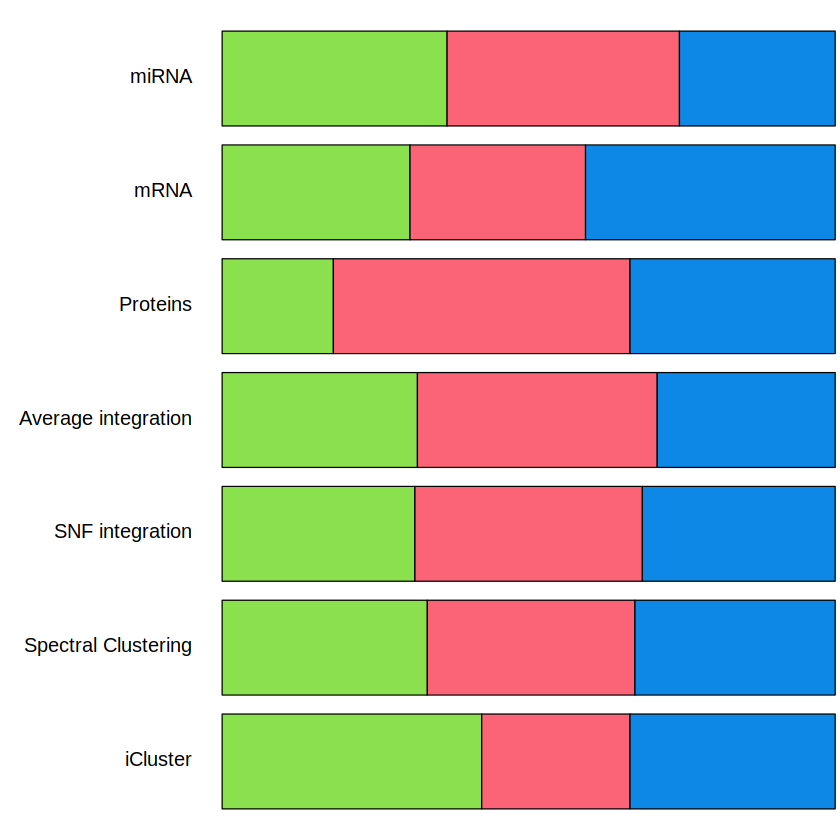

In [42]:
# pdf("myplot.pdf", height = 3)
oldp <- par(mar = c(0, 9, 0, .2))

data <- matrix(nrow = k, ncol = length(clusterings) + 1)
for (i in 1:length(clusterings))
	data[,i] <- as.vector(table(clusterings[[i]]$clustering))
data[,length(clusterings) + 1] <- as.vector(table(labels))

experiments = c("Spectral Clustering", "SNF integration", "Average integration", "Proteins", "mRNA", "miRNA")
data = data[, rev(seq_len(ncol(data)))]
barplot(data, names.arg = append("iCluster", experiments), horiz = TRUE, las = 1, col = c("#8be04e", "#FB6376", "#0d88e6"), xaxt='n')

In [43]:
#plot(princomp(complete[[3]])$scores, col = clusterings$SNFpam$clustering, main = "SNF (PAM)")

In [44]:
#eclust(as.dist(1-M_SNF), "kmeans", k = 3)

In [45]:
#fviz_pca_ind(res.pca<-prcomp(as.dist(1-M_SNF)),
#             palette = c("#00AFBB",  "#FC4E07"),
#             addEllipses = TRUE, # Concentration ellipses
#             ellipse.type = "confidence",
#             legend.title = "Groups",
#             repel = TRUE
#             )

In [46]:
# Plot pca results
pca <- function(data, clusters, title) {
  # Perform pca with two features
  res.pca <- prcomp(data)
  # Plot the result
  fviz_pca_ind(res.pca,
    geom.ind = "point",                   # Point to not show text
    col.ind  = as.factor(clusters),       # Color of the points to be the clusters
    palette = c("#8be04e", "#FB6376", "#0d88e6"),
    addEllipses = TRUE,                   # Elipse of the clustering region
    ellipse.type = "convex",              # Set the 'ellipse' to be the convex hull
    title=title,                          # Title of the plot
    legend.title = "Clusters",            # Title of the legent
    ggtheme = theme_bw()                # Custom theme
  )  
}

labels <- as.numeric(factor(subtypes$Subtype_Integrative, levels=unique(subtypes$Subtype_Integrative)));

png("iClusters.png", width = 1000, height = 1000)
pca(as.dist(1 - M_SNF), labels, title="iClusters");
dev.off();

png 
  2

In [47]:
png("AverageClusters.png", width = 1000, height = 1000)
pca(as.dist(1 - NetPreProc::Prob.norm(M_Mean)), clusterings$Meanpam$clustering, title="Average Clusters")
dev.off();

png 
  2

In [48]:
png("SNFClusters.png", width = 1000, height = 1000)
pca(as.dist(1 - M_SNF), clusterings$SNFpam$clustering, title="Similarity Network Fusion Clusters")
dev.off();

png 
  2

In [49]:
png("SpectralClusters.png", width = 1000, height = 1000)
pca(as.dist(1 - M_SNF), clusterings$SNFspectral$clustering, title="Spectral Clusters")
dev.off();

png 
  2